# Clasificación de Fugas con Escalogramas CWT

## 1. Instalación de Dependencias e Importación de Librerías

In [2]:
# Instalación de dependencias para wavelet denoising
!pip install PyWavelets

# Instalación de dependencias para fCWT
!git clone https://github.com/fastlib/fCWT.git
!pip install fCWT
!apt-get update
!apt-get install libfftw3-single3 -y

# Importación de bibliotecas necesarias
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import matplotlib.cm as cm
import scipy.signal as sig
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sns
import h5py
from tqdm import tqdm
import random
import pywt
import fcwt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import sys
import time
import datetime


# Importar la clase WaveletDenoising
from denoising import WaveletDenoising

# Montar Google Drive (para Colab)
from google.colab import drive
drive.mount('/content/drive')

# Configuraciones globales para visualización
plt.style.use('seaborn-v0_8-whitegrid')

fatal: destination path 'fCWT' already exists and is not an empty directory.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry miss

## 2. Cargar y Visualizar Datos

Data Directory: /content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched
Sample Rate: 25600 Hz
Classification Mode: five_classes
Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


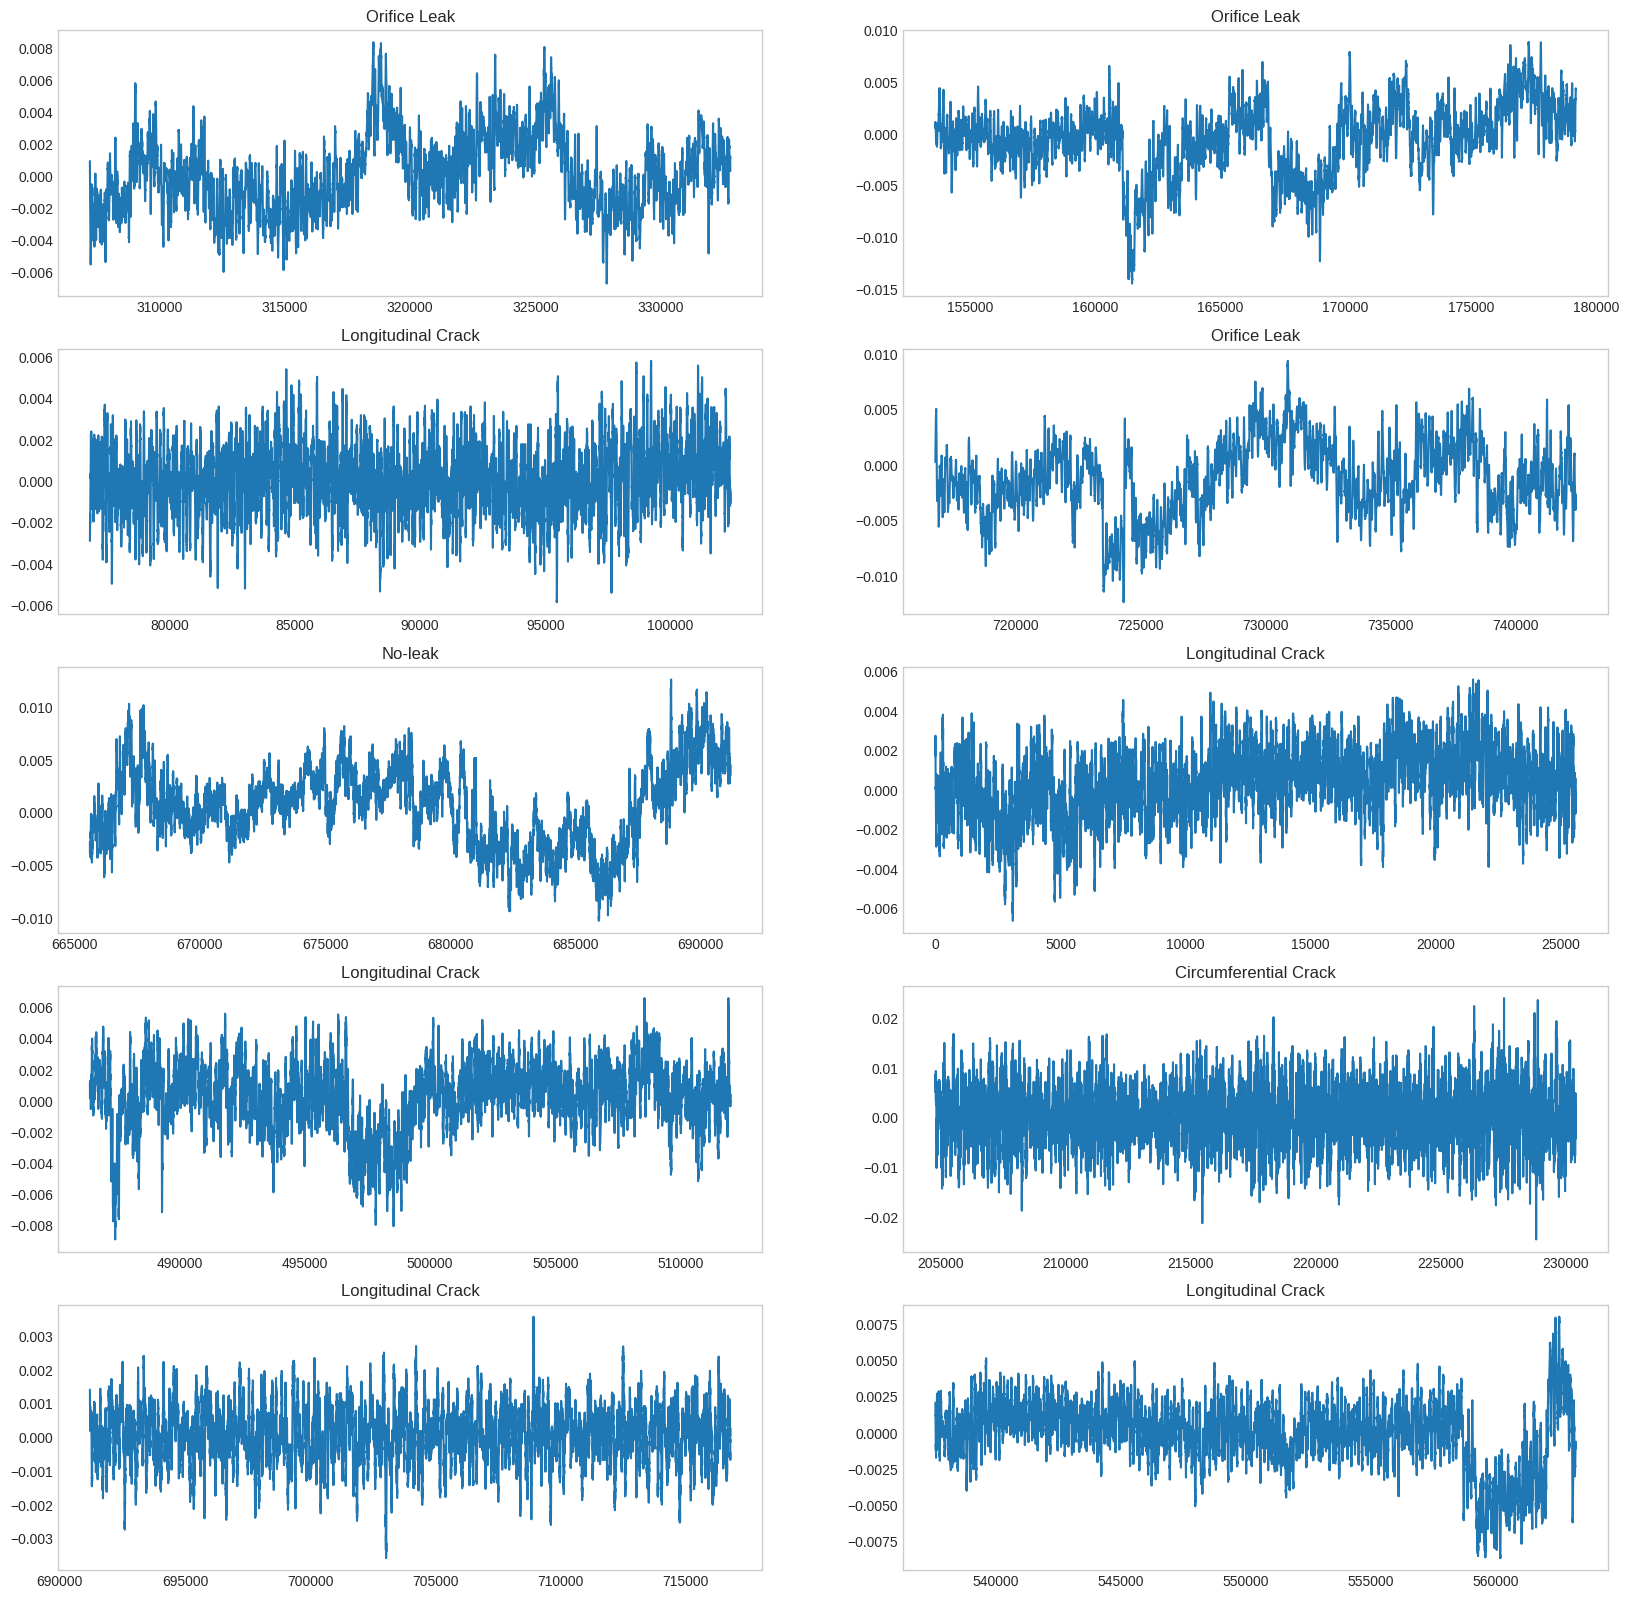

In [ ]:
# Cambiando la ruta para acceder a los datos en Google Drive
data_dir = '/content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched'
original_sr = 25600  # in Hz
signal_sr = 25600  # in Hz
downsample_factor = original_sr//signal_sr

# Modo de clasificación: 'five_classes' o 'binary'
classification_mode = 'five_classes'  # Cambiar según necesidad

# Definir diccionarios de etiquetas según el modo de clasificación
if classification_mode == 'five_classes':
    label_codes_dict = {'Circumferential Crack': 0, 'Gasket Leak': 1, 'Longitudinal Crack': 2, 'No-leak': 3, 'Orifice Leak': 4}
else:  # binary
    label_codes_dict = {'Leak': 0, 'No-leak': 1}

# Esta función elimina el archivo .DS_Store si existe en la ruta definida
def remove_DS_store_file(path):
    # Buscar tanto .DS_Store como .DS_store (diferencias de capitalización)
    for ds_name in ['.DS_Store', '.DS_store']:
        ds_store_file_location = os.path.join(path, ds_name)
        if os.path.isfile(ds_store_file_location):
            os.remove(ds_store_file_location)

def load_accelerometer_data(data_dir, sample_rate, downsample_factor, label_codes, mode='five_classes', fraction_to_include=1):
    """
    Carga datos de acelerómetro con opción para clasificación binaria o multiclase

    Args:
        data_dir: Directorio donde se encuentran los datos
        sample_rate: Tasa de muestreo deseada
        downsample_factor: Factor de submuestreo
        label_codes: Diccionario de códigos de etiquetas
        mode: 'five_classes' o 'binary'
        fraction_to_include: Fracción de frames a incluir

    Returns:
        signals: Lista de señales
        labels: Lista de etiquetas
    """
    # Eliminar .DS_Store si existe en data_dir
    remove_DS_store_file(data_dir)

    signals = []
    labels = []

    # Para el modo binario, necesitamos contabilizar cuántos frames hay por cada tipo de fuga
    leak_counts = {
        'Circumferential Crack': 0,
        'Gasket Leak': 0,
        'Longitudinal Crack': 0,
        'Orifice Leak': 0
    }
    leak_signals = {
        'Circumferential Crack': [],
        'Gasket Leak': [],
        'Longitudinal Crack': [],
        'Orifice Leak': []
    }
    no_leak_signals = []
    no_leak_labels = []

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)

        # Verificar que sea un directorio antes de procesarlo
        if not os.path.isdir(label_dir):
            print(f"Omitiendo {label_dir} porque no es un directorio")
            continue

        # Eliminar .DS_Store si existe
        remove_DS_store_file(label_dir)

        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)

            # Verificar que sea un archivo
            if not os.path.isfile(file_path):
                continue

            # Cargar el archivo csv
            accelerometer_signal_df = pd.read_csv(file_path, index_col=False)

            # Submuestrear seleccionando cada n-ésima fila
            accelerometer_signal_df = accelerometer_signal_df.iloc[::downsample_factor, :]
            accelerometer_signal_df = accelerometer_signal_df.reset_index(drop=True)

            # Obtener 30 segundos de datos
            accelerometer_signal = accelerometer_signal_df['Value'][0:(sample_rate*30)]

            # Generar un vector con el índice de inicio para cada frame de 1 segundo
            sample_indexes = np.linspace(0,len(accelerometer_signal)-sample_rate,len(accelerometer_signal)//sample_rate)

            # Obtener el número de frames de señal
            signal_frames_number = fraction_to_include*len(sample_indexes)
            signal_frames_counter = 0

            # Generar frames de señal de 1 segundo a partir de la señal original
            for signal_frame in sample_indexes:
                accelerometer_signal_frame = accelerometer_signal[int(signal_frame):int(signal_frame+sample_rate)]
                signal_frames_counter+=1

                if signal_frames_counter > signal_frames_number:
                    break

                if len(accelerometer_signal_frame) != sample_rate:
                    continue

                if mode == 'five_classes':
                    # Guardar directamente para clasificación de 5 clases
                    signals.append(accelerometer_signal_frame)
                    labels.append(label_codes[label])
                else:  # modo binario
                    # Para modo binario, guardamos las señales según su tipo
                    if label == 'No-leak':
                        no_leak_signals.append(accelerometer_signal_frame)
                        no_leak_labels.append(1)  # 1 para No-leak en modo binario
                    else:
                        # Guardar en la categoría correspondiente
                        leak_signals[label].append(accelerometer_signal_frame)
                        leak_counts[label] += 1

    # Si estamos en modo binario, equilibramos el dataset
    if mode == 'binary':
        # Encontrar la cantidad mínima de ejemplos por tipo de fuga
        min_count_per_leak_type = min(leak_counts.values()) if leak_counts else 0

        # Calcular cuántos ejemplos necesitamos de cada tipo para equilibrar con No-leak
        if len(no_leak_signals) > 0 and len(leak_counts) > 0:
            total_leak_samples_needed = len(no_leak_signals)
            samples_per_leak_type = total_leak_samples_needed // len(leak_counts)

            # Asegurar que no tomamos más muestras de las disponibles
            samples_per_leak_type = min(samples_per_leak_type, min_count_per_leak_type)

            # Seleccionar muestras equilibradas de cada tipo de fuga
            balanced_leak_signals = []
            for leak_type in leak_signals:
                if leak_signals[leak_type]:
                    # Tomar una muestra aleatoria del tamaño necesario
                    selected_signals = random.sample(leak_signals[leak_type],
                                                    min(samples_per_leak_type, len(leak_signals[leak_type])))
                    balanced_leak_signals.extend(selected_signals)

            # Crear etiquetas para las señales de fuga (0 para Leak en modo binario)
            balanced_leak_labels = [0] * len(balanced_leak_signals)

            # Combinar todo
            signals = balanced_leak_signals + no_leak_signals
            labels = balanced_leak_labels + no_leak_labels

            print(f"Modo binario: {len(balanced_leak_labels)} muestras de fuga, {len(no_leak_labels)} muestras sin fuga")

    return signals, labels

# Cargar los datos desde Google Drive
signals_lst, labels_lst = load_accelerometer_data(
    data_dir,
    signal_sr,
    downsample_factor,
    label_codes_dict,
    mode=classification_mode,
    fraction_to_include=1
)

signals_dict = {'training': [], 'testing': []}
labels_dict = {'training': [], 'testing': []}

# Generar diccionarios con subconjuntos de entrenamiento y prueba a partir de los datos cargados
signals_dict['training'], signals_dict['testing'], labels_dict['training'], labels_dict['testing'] = train_test_split(
    signals_lst,
    labels_lst,
    test_size=0.2,
    random_state=53
)

# Imprimir información sobre el dataset resultante:
print(f'Data Directory: {data_dir}')
print(f'Sample Rate: {signal_sr} Hz')
print(f'Classification Mode: {classification_mode}')
print(f'Number of signals (training, testing): ({len(signals_dict["training"])}, {len(signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(signals_dict["training"][np.random.randint(0,len(signals_dict["training"]))])}')

# Graficar algunas de las señales resultantes
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols
random_index = []

for i in range(n):
    plt.subplot(rows, cols, i+1)
    random_index.append(np.random.randint(0, len(signals_dict['training'])))
    plt.plot(signals_dict['training'][random_index[i]])

    # Obtener el nombre de la etiqueta según el modo de clasificación
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()

## 3. Normalización y Denoising con Wavelet

Denoising testing signals: 100%|██████████| 240/240 [00:00<00:00, 342.63it/s]


Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


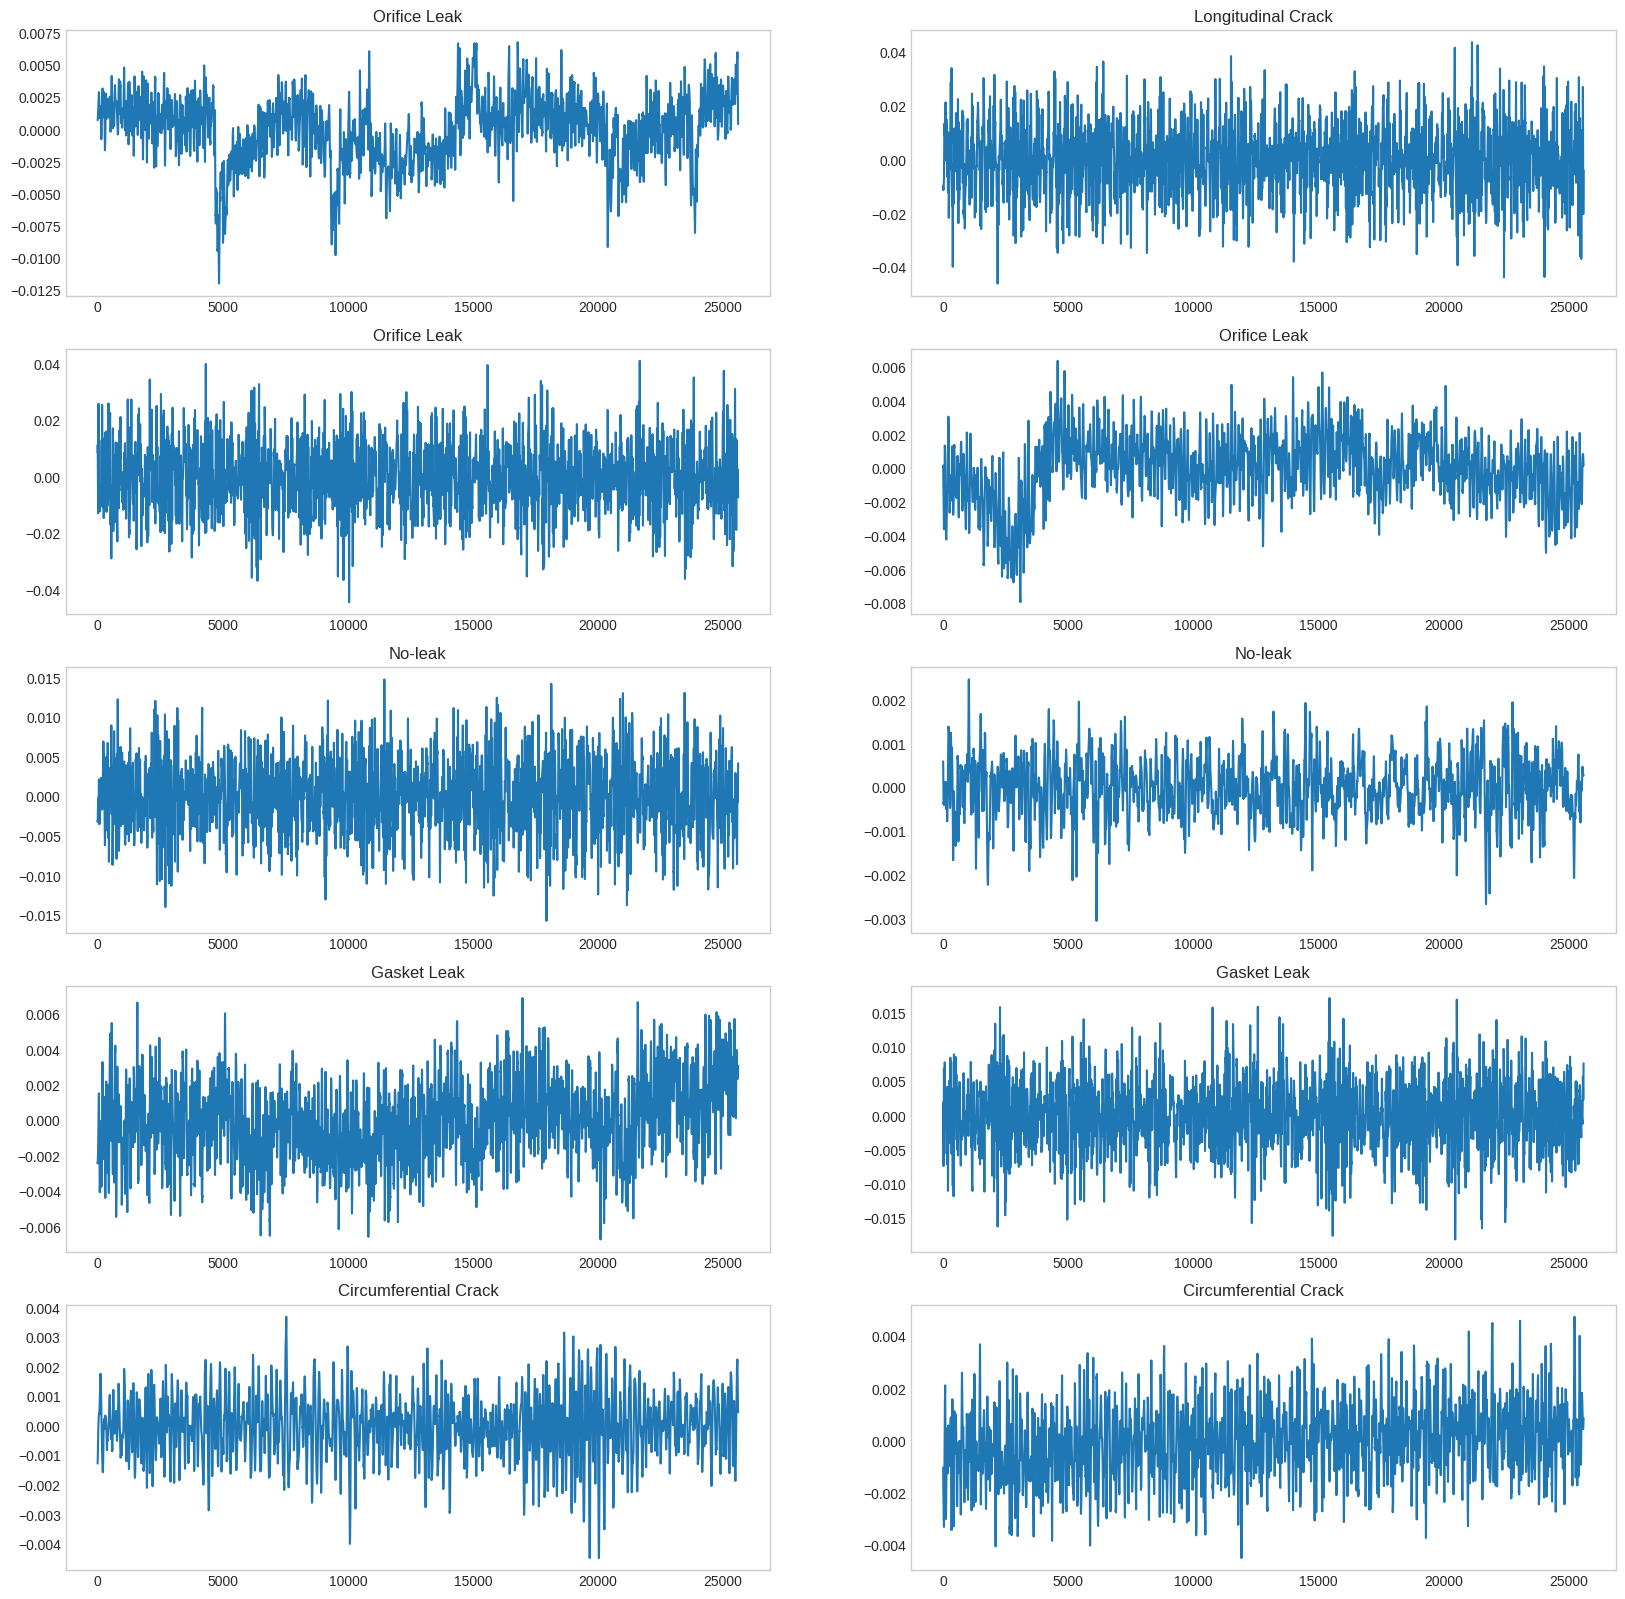

In [ ]:
def wavelet_denoise(signals_dict, labels_dict):
    """
    Normaliza y aplica denoising wavelet a las señales

    Args:
        signals_dict: Diccionario con señales de entrenamiento y prueba
        labels_dict: Diccionario con etiquetas de entrenamiento y prueba

    Returns:
        wavelet_denoised_signals: Diccionario con señales procesadas
        labels_dict: Diccionario con etiquetas
    """
    # Crear un objeto de la clase WaveletDenoising
    wd = WaveletDenoising(normalize=True,
                      wavelet='sym3',
                      level=4,
                      thr_mode='soft',
                      method="universal")

    # Crear un nuevo diccionario para almacenar los coeficientes calculados:
    wavelet_denoised_signals = {'training': [], 'testing': []}

    for key, signals_subset in signals_dict.items():
        for signal_element in tqdm(signals_subset, desc=f"Denoising {key} signals"):
            # Denoising de la señal usando el método wavelet denoising
            denoised_signal = wd.fit(signal_element)

            # Almacenar las señales denoised en el nuevo diccionario
            wavelet_denoised_signals[key].append(denoised_signal)

    return wavelet_denoised_signals, labels_dict

# Denoising de las señales en los diccionarios de entrenamiento y prueba
wavelet_denoised_signals_dict, labels_dict = wavelet_denoise(signals_dict=signals_dict, labels_dict=labels_dict)

# Imprimir información sobre el dataset resultante:
print(f'Number of signals (training, testing): ({len(wavelet_denoised_signals_dict["training"])}, {len(wavelet_denoised_signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(wavelet_denoised_signals_dict["training"][0])}')

# Graficar algunas de las señales resultantes
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.plot(wavelet_denoised_signals_dict['training'][random_index[i]])

    # Obtener el nombre de la etiqueta según el modo de clasificación
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()

## 4. Cálculo de Escalogramas con CWT

### 4.1 Función para calcular los escalogramas aplicando el CONE OF INFLUENCE

In [ ]:
def calculate_cwt_with_coi(signal, fs=25600, f0=1.0, f1=None, fn=64,
                          sigma=6.0, fast=True, norm=True, scaling="log", nthreads=8):
    """
    Calcula la CWT de una señal utilizando la biblioteca fCWT con manejo del COI.
    """
    # Verificar tipo de datos y convertir si es necesario
    signal = np.array(signal, dtype=np.float32)

    # Establecer frecuencia máxima si no se especifica
    if f1 is None:
        f1 = fs/2

    # Inicializar la wavelet Morlet con el sigma especificado
    morlet = fcwt.Morlet(sigma)

    # Configurar escalas según el tipo de escalado
    if scaling.lower() == "log":
        scale_type = fcwt.FCWT_LOGSCALES
    else:
        scale_type = fcwt.FCWT_LINFREQS

    # Inicializar escalas como objeto
    scales_obj = fcwt.Scales(morlet, scale_type, fs, f0, f1, fn)

    # Extraer valores de escalas y frecuencias a arrays de NumPy
    # Crear arrays para almacenar los valores
    scales_array = np.zeros(fn, dtype=np.float32)
    freqs_array = np.zeros(fn, dtype=np.float32)

    # Llenar los arrays con los valores - estos métodos modifican los arrays pasados
    scales_obj.getScales(scales_array)
    scales_obj.getFrequencies(freqs_array)

    # Inicializar objeto FCWT
    fcwt_obj = fcwt.FCWT(morlet, nthreads, fast, norm)

    # Inicializar matriz de salida
    cwt_output = np.zeros((fn, len(signal)), dtype=np.complex64)

    # Calcular CWT - usar el objeto scales_obj directamente, no el array
    fcwt_obj.cwt(signal, scales_obj, cwt_output)

    # Calcular la máscara del COI usando el array de escalas (no el objeto)
    coi_mask = calculate_coi_mask(cwt_output, scales_array, len(signal), sigma)

    return freqs_array, cwt_output, coi_mask, scales_array


### 4.2 Función para calcular la máscara COI en la CWT

In [ ]:
def calculate_coi_mask(cwt_output, scales, signal_length, sigma=6.0):
    """
    Calcula la máscara del Cone of Influence (COI) para un escalograma CWT.
    Ahora 'scales' es un array de NumPy, no un objeto SwigPyObject.
    """
    mask = np.ones_like(cwt_output, dtype=bool)

    # Calcular la máscara del COI para cada escala
    for i in range(len(scales)):
        scale = scales[i]  # Acceder a cada valor individualmente

        # El ancho del borde es proporcional a la escala y sigma
        border_width = int(np.ceil(sigma * np.sqrt(2) * scale))

        # Limitar el ancho del borde
        border_width = min(border_width, signal_length // 2)

        # Marcar regiones del COI como False
        if border_width > 0:
            mask[i, :border_width] = False
            mask[i, -border_width:] = False

    return mask

### 4.3 Función que te genera los escalogramas ya aplicando el COI

In [ ]:
def get_cwt_features_with_coi(signals, labels, fs=25600, f0=1.0, f1=None, fn=64,
                           sigma=6.0, nthreads=8, scaling="log", fast=True, norm=True,
                           segment_size=512):
    """
    Calcula escalogramas CWT usando fCWT con aplicación de la máscara del COI.
    """
    # Configuración inicial
    if f1 is None:
        f1 = fs/2  # Frecuencia de Nyquist

    # Estructuras para almacenar resultados
    scalograms = []
    scalograms_with_coi = []  # Escalogramas sin aplicar máscara de COI
    segment_labels = []
    coi_percentages = []

    print(f"Calculando escalogramas con wavelet Morlet (sigma={sigma})")
    print(f"Rango de frecuencias: {f0} - {f1} Hz, {fn} bandas")

    # Procesar cada señal
    for i, (signal, label) in enumerate(tqdm(zip(signals, labels), total=len(signals), desc="Calculando CWT con COI")):
        # Dividir en segmentos
        num_segments = len(signal) // segment_size

        for j in range(num_segments):
            # Extraer segmento
            segment = signal[j*segment_size:(j+1)*segment_size]

            try:
                # Calcular CWT con manejo del COI
                freqs, cwt_coef, coi_mask, scales = calculate_cwt_with_coi(
                    segment, fs, f0, f1, fn, sigma, fast, norm, scaling, nthreads
                )

                # Calcular porcentaje de coeficientes dentro del COI válido
                valid_percentage = np.mean(coi_mask) * 100
                coi_percentages.append(valid_percentage)

                # Crear escalograma completo (sin aplicar máscara)
                scalogram_full = np.square(np.abs(cwt_coef)).T

                # Crear escalograma con COI aplicado (NaN en los bordes afectados)
                scalogram_coi = scalogram_full.copy()
                scalogram_coi[coi_mask.T] = 0

                # Normalizar escalogramas
                max_val_full = np.nanmax(scalogram_full)
                if max_val_full > 0:
                    scalogram_full = scalogram_full / max_val_full
                    scalogram_coi = scalogram_coi / max_val_full

                # Para entrenamiento, reemplazar NaN con ceros
                training_scalogram = np.nan_to_num(scalogram_coi, nan=0.0)

                # Almacenar resultados
                scalograms.append(training_scalogram)
                scalograms_with_coi.append(scalogram_full)
                segment_labels.append(label)

            except Exception as e:
                print(f"Error en segmento {j} de señal {i}: {e}")
                continue

    # Mostrar información sobre los escalogramas generados
    if len(coi_percentages) > 0:
        avg_valid = np.mean(coi_percentages)
        print(f"Escalogramas calculados: {len(scalograms)}")
        print(f"Porcentaje promedio de datos válidos (fuera del COI): {avg_valid:.2f}%")
        if len(scalograms) > 0:
            print(f"Forma de un escalograma: {scalograms[0].shape}")

    return scalograms, segment_labels, coi_percentages, scalograms_with_coi

### 4.4 Función para visualizar los escalogramas y ver la diferencia entre el uso del COI  y el escalograma general

In [ ]:
# Función para visualizar los escalogramas COI vs original
def plot_cwt_scalograms_comparison(scalograms_original, scalograms_coi, labels,
                                  label_codes_dict, num_per_class=2,
                                  fs=25600, segment_size=512, sigma=6.0):
    """
    Visualiza una comparación entre escalogramas originales y con COI aplicado.
    """
    # Configuración de visualización
    t_duration = segment_size / fs
    f0 = 1.0
    f1 = fs/2

    # Configurar subplot grid
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    rows = num_classes
    cols = 2 * num_per_class

    plt.figure(figsize=(15, 4*rows))

    for i, label_code in enumerate(unique_labels):
        # Obtener índices de esta clase
        class_indices = [idx for idx, l in enumerate(labels) if l == label_code]

        if len(class_indices) == 0:
            continue

        # Seleccionar ejemplos aleatorios
        selected_indices = random.sample(class_indices, min(num_per_class, len(class_indices)))

        for j, idx in enumerate(selected_indices):
            # Obtener etiqueta en texto
            if 'classification_mode' in globals() and globals()['classification_mode'] == 'five_classes':
                label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(label_code)]
            else:
                label_name = 'Leak' if label_code == 0 else 'No-leak'

            # Escalograma original
            ax = plt.subplot(rows, cols, i*cols + j*2 + 1)
            im = ax.imshow(scalograms_original[idx], aspect='auto', origin='lower',
                         extent=[0, t_duration, f0, f1], cmap=cm.viridis)
            ax.set_yscale('log')
            ax.set_title(f"Original: {label_name}")
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Frecuencia (Hz)')
            plt.colorbar(im, ax=ax, label='Energía')

            # Escalograma con COI aplicado
            ax = plt.subplot(rows, cols, i*cols + j*2 + 2)
            im = ax.imshow(scalograms_coi[idx], aspect='auto', origin='lower',
                         extent=[0, t_duration, f0, f1], cmap=cm.viridis)
            ax.set_yscale('log')
            ax.set_title(f"COI aplicado: {label_name} (σ={sigma})")
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Frecuencia (Hz)')
            plt.colorbar(im, ax=ax, label='Energía')

    plt.tight_layout()
    plt.show()

## 5. Función para crear el modelo ResNet regularizado

In [16]:
# Implementación del bloque residual regularizado
def residual_block_with_reg(x, filters, kernel_size=3, stride=1, conv_shortcut=False, reg=None):
    """
    Bloque residual con regularización
    """
    shortcut = x

    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', kernel_regularizer=reg)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.ReLU()(x)

    return x

# Función para construir el modelo ResNet18 regularizado
def build_cwt_resnet18_with_regularization(input_shape, num_classes=5):
    """
    Construye un modelo ResNet18 con regularización para escalogramas CWT
    """
    inputs = layers.Input(shape=input_shape)

    # Regularizador L2
    reg = keras.regularizers.l2(0.001)

    # Bloque inicial con regularización
    x = layers.Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=reg)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    x = layers.Dropout(0.2)(x)  # Dropout después del primer bloque

    # ResNet bloques con regularización
    x = residual_block_with_reg(x, 64, reg=reg)
    x = residual_block_with_reg(x, 64, reg=reg)
    x = layers.Dropout(0.3)(x)

    x = residual_block_with_reg(x, 128, stride=2, conv_shortcut=True, reg=reg)
    x = residual_block_with_reg(x, 128, reg=reg)
    x = layers.Dropout(0.3)(x)

    x = residual_block_with_reg(x, 256, stride=2, conv_shortcut=True, reg=reg)
    x = residual_block_with_reg(x, 256, reg=reg)
    x = layers.Dropout(0.4)(x)

    x = residual_block_with_reg(x, 512, stride=2, conv_shortcut=True, reg=reg)
    x = residual_block_with_reg(x, 512, reg=reg)

    # Capa de clasificación
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=reg)(x)
    x = layers.Dropout(0.5)(x)

    # Capa de salida según el número de clases
    if num_classes == 2:  # Clasificación binaria
        outputs = layers.Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
    else:  # Clasificación multiclase
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        loss = 'categorical_crossentropy'

    model = keras.Model(inputs, outputs, name="cwt_resnet18_regularized")

    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss=loss,
        metrics=['accuracy']
    )

    return model

### 5.1 Funcion para salvar los datasets

In [17]:
# Función para guardar datasets procesados
def save_cwt_dataset(file_path, x_train, y_train, x_test, y_test, classification_mode, label_codes_dict=None):
    """
    Guarda el dataset de escalogramas procesados en formato HDF5
    """
    # Crear directorio si no existe
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Determinar número de clases
    num_classes = 5 if classification_mode == 'five_classes' else 2

    # Dividir conjunto de entrenamiento para crear un conjunto de validación
    val_split = 0.2
    val_indices = np.random.choice(len(x_train), int(len(x_train) * val_split), replace=False)
    train_mask = np.ones(len(x_train), dtype=bool)
    train_mask[val_indices] = False

    x_val = x_train[~train_mask]
    y_val = y_train[~train_mask]
    x_train = x_train[train_mask]
    y_train = y_train[train_mask]

    # Convertir etiquetas a one-hot
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)

    # Guardar en formato HDF5
    with h5py.File(file_path, 'w') as hf:
        # Crear grupos
        train_group = hf.create_group('train')
        val_group = hf.create_group('val')
        test_group = hf.create_group('test')
        metadata_group = hf.create_group('metadata')
        shapes_group = hf.create_group('shapes')

        # Guardar conjuntos de datos
        train_group.create_dataset('x_train', data=x_train)
        train_group.create_dataset('y_train', data=y_train)
        train_group.create_dataset('y_train_onehot', data=y_train_onehot)

        val_group.create_dataset('x_val', data=x_val)
        val_group.create_dataset('y_val', data=y_val)
        val_group.create_dataset('y_val_onehot', data=y_val_onehot)

        test_group.create_dataset('x_test', data=x_test)
        test_group.create_dataset('y_test', data=y_test)
        test_group.create_dataset('y_test_onehot', data=y_test_onehot)

        # Guardar metadatos
        metadata_group.attrs['num_classes'] = num_classes
        metadata_group.attrs['classification_mode'] = classification_mode

        # Guardar formas
        shapes_group.attrs['x_train_shape'] = x_train.shape
        shapes_group.attrs['x_val_shape'] = x_val.shape
        shapes_group.attrs['x_test_shape'] = x_test.shape

    # Si hay un diccionario de códigos de etiquetas, guardarlo en un archivo de texto
    if label_codes_dict is not None:
        classes_file = file_path.replace('.h5', '_classes.txt')
        with open(classes_file, 'w') as f:
            for name, code in label_codes_dict.items():
                f.write(f"{name}: {code}\n")

    print(f"Dataset guardado en: {file_path}")
    print(f"Información del dataset guardado:")
    print(f"- Modo de clasificación: {classification_mode}")
    print(f"- Número de clases: {num_classes}")
    print(f"- Muestras de entrenamiento: {len(x_train)}")
    print(f"- Muestras de validación: {len(x_val)}")
    print(f"- Muestras de prueba: {len(x_test)}")
    print(f"- Forma de los datos: {x_train.shape}")

    return {
        'x_train': x_train,
        'y_train': y_train,
        'y_train_onehot': y_train_onehot,
        'x_val': x_val,
        'y_val': y_val,
        'y_val_onehot': y_val_onehot,
        'x_test': x_test,
        'y_test': y_test,
        'y_test_onehot': y_test_onehot
    }

### 5.2 Función para preparar los datos para que sean entrada de una CNN

In [18]:
# Función para preparar datos para CNN
def prepare_data_for_cnn(scalograms, labels, input_shape=None):
    """Prepara los escalogramas para CNN añadiendo canal de color y redimensionando si es necesario."""
    X = np.array(scalograms)
    y = np.array(labels)

    # Añadir canal de color (escala de grises = 1 canal)
    if len(X.shape) == 3:
        X = X.reshape(X.shape + (1,))


    return X, y

## 6.Obtención de escalogramas con diferentes sigmas

In [ ]:

# Definimos los valores de sigma a evaluar
sigma_values = [10.0]
results = {}
# Calcular escalogramas para cada valor de sigma
for sigma in sigma_values:
    print(f"\n=== Calculando escalogramas con sigma = {sigma} ===")

    # Calcular escalogramas con manejo del COI
    train_scalograms, train_labels, train_coi_percentages, train_scalograms_full = get_cwt_features_with_coi(
        wavelet_denoised_signals_dict['training'],
        labels_dict['training'],
        segment_size=512,
        fn=10,
        sigma=sigma,
        scaling="log",
        nthreads=1
    )

    test_scalograms, test_labels, test_coi_percentages, test_scalograms_full = get_cwt_features_with_coi(
        wavelet_denoised_signals_dict['testing'],
        labels_dict['testing'],
        segment_size=512,
        fn=10,
        sigma=sigma,
        scaling="log",
        nthreads=1
    )

    # Mostrar información
    print(f"Escalogramas de entrenamiento: {len(train_scalograms)}")
    print(f"Escalogramas de prueba: {len(test_scalograms)}")

    if len(train_scalograms) > 0:
        print(f"Forma de un escalograma: {train_scalograms[0].shape}")

    # Guardar resultados para este sigma
    results[sigma] = {
        'train_scalograms': train_scalograms,
        'train_labels': train_labels,
        'test_scalograms': test_scalograms,
        'test_labels': test_labels,
        'train_scalograms_full': train_scalograms_full,
        'test_scalograms_full': test_scalograms_full
    }

    # Guardar los escalogramas en formato npz para evitar cálculos repetidos
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    np.savez_compressed(
        f'coi_scalograms_sigma_{sigma}_{timestamp}.npz',
        train_scalograms=train_scalograms,
        train_labels=train_labels,
        test_scalograms=test_scalograms,
        test_labels=test_labels,
        train_scalograms_full=train_scalograms_full,
        test_scalograms_full=test_scalograms_full,
        sigma=sigma
    )
    print(f"Escalogramas con sigma={sigma} guardados con éxito.")

print("\nProcesamiento de escalogramas completado para todos los valores de sigma.")


=== Calculando escalogramas con sigma = 10.0 ===
Calculando escalogramas con wavelet Morlet (sigma=10.0)
Rango de frecuencias: 1.0 - 12800.0 Hz, 10 bandas


Calculando CWT con COI: 100%|██████████| 960/960 [00:49<00:00, 19.43it/s]


Escalogramas calculados: 48000
Porcentaje promedio de datos válidos (fuera del COI): 16.64%
Forma de un escalograma: (512, 10)
Calculando escalogramas con wavelet Morlet (sigma=10.0)
Rango de frecuencias: 1.0 - 12800.0 Hz, 10 bandas


Calculando CWT con COI: 100%|██████████| 240/240 [00:07<00:00, 33.26it/s]


Escalogramas calculados: 12000
Porcentaje promedio de datos válidos (fuera del COI): 16.64%
Forma de un escalograma: (512, 10)
Escalogramas de entrenamiento: 48000
Escalogramas de prueba: 12000
Forma de un escalograma: (512, 10)
Escalogramas con sigma=10.0 guardados con éxito.

Procesamiento de escalogramas completado para todos los valores de sigma.


## 7.Visualización de escalogramas con/sin COI


=== Visualizando escalogramas con sigma = 10.0 ===


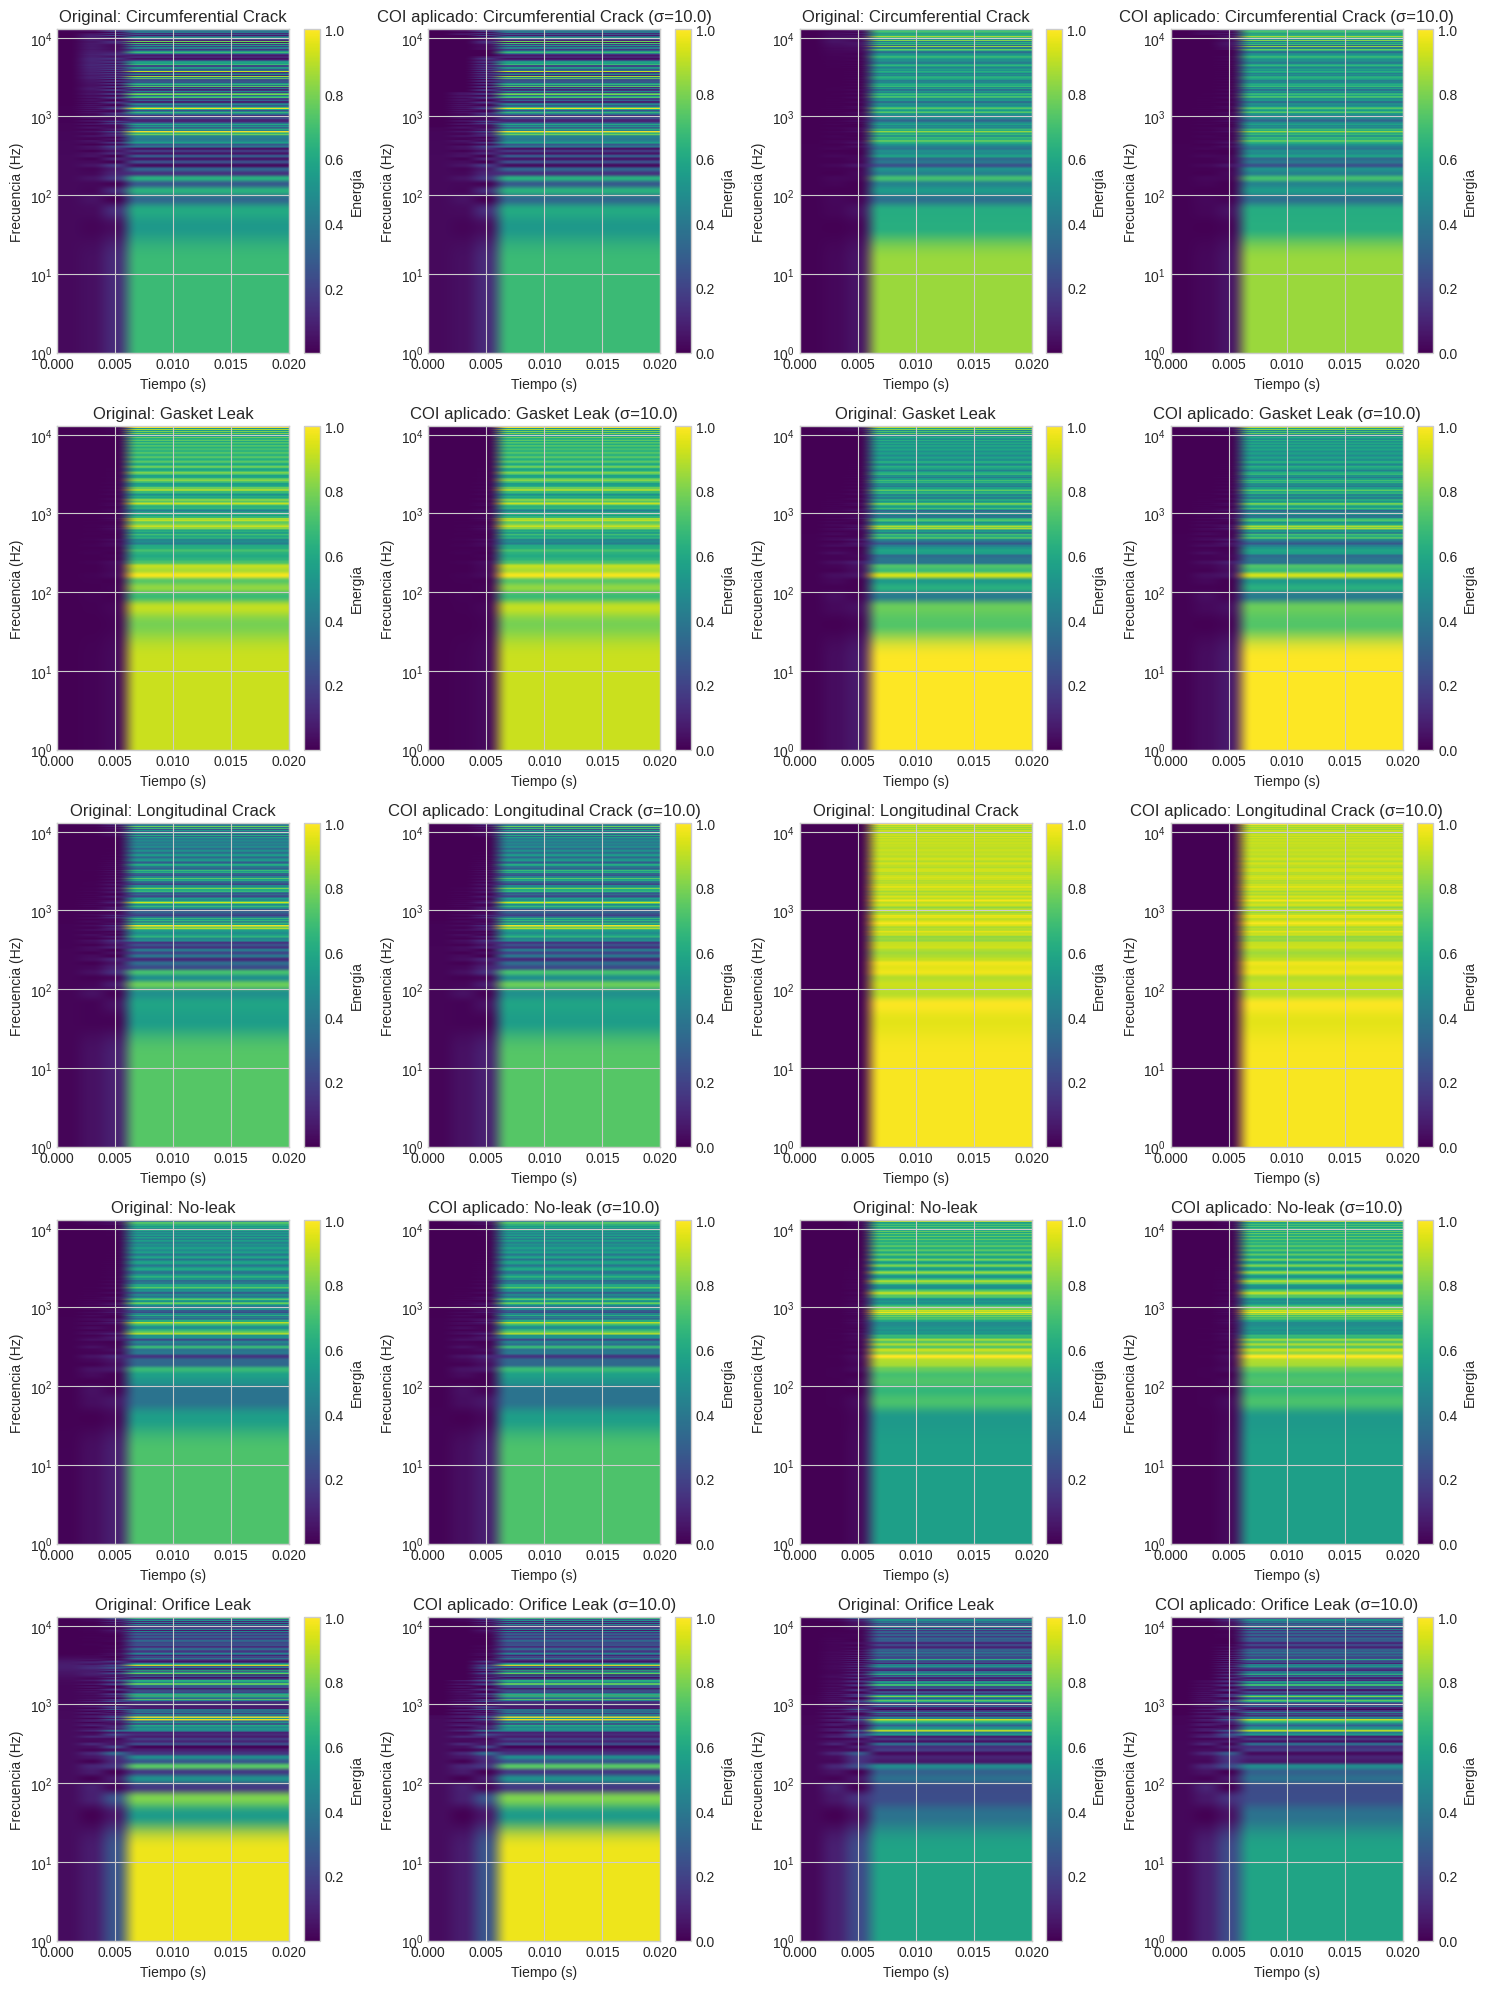

In [ ]:
# Visualizar escalogramas para cada sigma
for sigma in sigma_values:
    print(f"\n=== Visualizando escalogramas con sigma = {sigma} ===")

    # Obtener los escalogramas para este sigma
    train_scalograms_full = results[sigma]['train_scalograms_full']
    train_scalograms = results[sigma]['train_scalograms']
    train_labels = results[sigma]['train_labels']

    # Visualizar comparación entre original y con COI
    plot_cwt_scalograms_comparison(
        train_scalograms_full,
        train_scalograms,
        train_labels,
        label_codes_dict,
        num_per_class=2,
        sigma=sigma
    )

## 8. Preparando los datos para el entrenamiento de la CNN

In [ ]:
# Preparar datos para cada sigma


prepared_data = {}
for sigma in sigma_values:
    print(f"\n=== Preparando datos para sigma = {sigma} ===")

    # Obtener datos
    train_scalograms = results[sigma]['train_scalograms']
    train_labels = results[sigma]['train_labels']
    test_scalograms = results[sigma]['test_scalograms']
    test_labels = results[sigma]['test_labels']



    # MEZCLA DE DATOS - Paso 1: Convertir a numpy arrays
    train_scalograms_array = np.array(train_scalograms)
    train_labels_array = np.array(train_labels)
    test_scalograms_array = np.array(test_scalograms)
    test_labels_array = np.array(test_labels)

    # MEZCLA DE DATOS - Paso 2: Crear índices aleatorios
    np.random.seed(42)  # Para reproducibilidad
    train_indices = np.random.permutation(len(train_scalograms_array))
    test_indices = np.random.permutation(len(test_scalograms_array))

    # MEZCLA DE DATOS - Paso 3: Reorganizar datos
    train_scalograms_shuffled = train_scalograms_array[train_indices]
    train_labels_shuffled = train_labels_array[train_indices]
    test_scalograms_shuffled = test_scalograms_array[test_indices]
    test_labels_shuffled = test_labels_array[test_indices]

    print(f"Datos mezclados manteniendo coherencia entre escalogramas y etiquetas")

    # Preparar datos para CNN
    X_train, y_train = prepare_data_for_cnn(train_scalograms_shuffled, train_labels_shuffled, train_scalograms_shuffled.shape[:2])
    X_test, y_test = prepare_data_for_cnn(test_scalograms_shuffled, test_labels_shuffled, train_scalograms_shuffled.shape[:2])

    print(f"Forma de datos de entrenamiento: {X_train.shape}")
    print(f"Distribución de clases en entrenamiento: {np.bincount(y_train)}")

    # Guardar datos preparados
    prepared_data[sigma] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }
    # Guardar dataset en formato HDF5
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    file_path = f'cwt_coi_sigma_{sigma}_{timestamp}.h5'

    if 'google.colab' in sys.modules:  # Si estamos en Colab, usar la ruta de Drive
        file_path = f'/content/drive/MyDrive/Tesis/Datasets/{file_path}'

    # Guardar dataset procesado
    print(f"Guardando dataset procesado para sigma={sigma}...")

    # Determinar el modo de clasificación
    mode = 'five_classes' if 'classification_mode' in globals() and globals()['classification_mode'] == 'five_classes' else 'binary'

    dataset_info = save_cwt_dataset(
        file_path,
        X_train, y_train,
        X_test, y_test,
        mode,
        label_codes_dict if 'label_codes_dict' in globals() else None
    )

    # Guardar también en prepared_data
    prepared_data[sigma]['dataset_file'] = file_path
    prepared_data[sigma]['dataset_info'] = dataset_info

print("\nPreparación de datos completada para todos los valores de sigma.")


=== Preparando datos para sigma = 10.0 ===
Datos mezclados manteniendo coherencia entre escalogramas y etiquetas
Forma de datos de entrenamiento: (48000, 512, 10, 1)
Distribución de clases en entrenamiento: [9950 9650 9600 9450 9350]
Guardando dataset procesado para sigma=10.0...
Dataset guardado en: /content/drive/MyDrive/Tesis/Datasets/cwt_coi_sigma_10.0_20250327_024300.h5
Información del dataset guardado:
- Modo de clasificación: five_classes
- Número de clases: 5
- Muestras de entrenamiento: 38400
- Muestras de validación: 9600
- Muestras de prueba: 12000
- Forma de los datos: (38400, 512, 10, 1)

Preparación de datos completada para todos los valores de sigma.


In [12]:

##FUNCION PARA CARGAR LOS DATOS
# 5.2 Cargar Dataset de Escalogramas con COI

def load_cwt_dataset(load_path):
    """
    Carga el dataset de escalogramas procesados con COI.

    Args:
        load_path: Ruta del archivo del dataset a cargar

    Returns:
        Diccionario con todos los datos y metadatos del dataset
    """
    import os
    dataset = {}

    # Verificar si el archivo existe
    if not os.path.exists(load_path):
        print(f"Error: El archivo {load_path} no existe.")
        return None

    # Cargar desde archivo HDF5
    with h5py.File(load_path, 'r') as hf:
        # Cargar datos de entrenamiento
        dataset['x_train'] = hf['train/x_train'][:]
        dataset['y_train'] = hf['train/y_train'][:]
        dataset['y_train_onehot'] = hf['train/y_train_onehot'][:]

        # Cargar datos de validación
        dataset['x_val'] = hf['val/x_val'][:]
        dataset['y_val'] = hf['val/y_val'][:]
        dataset['y_val_onehot'] = hf['val/y_val_onehot'][:]

        # Cargar datos de prueba
        dataset['x_test'] = hf['test/x_test'][:]
        dataset['y_test'] = hf['test/y_test'][:]
        dataset['y_test_onehot'] = hf['test/y_test_onehot'][:]

        # Cargar metadatos
        dataset['num_classes'] = hf['metadata'].attrs['num_classes']
        dataset['classification_mode'] = hf['metadata'].attrs['classification_mode']

        # Cargar información de formas
        dataset['shapes'] = {
            'x_train_shape': hf['shapes'].attrs['x_train_shape'],
            'x_val_shape': hf['shapes'].attrs['x_val_shape'],
            'x_test_shape': hf['shapes'].attrs['x_test_shape']
        }

        # Obtener forma de escalograma individual si está disponible
        if 'scalogram_shape' in hf['shapes'].attrs:
            dataset['shapes']['scalogram_shape'] = hf['shapes'].attrs['scalogram_shape']

    # Cargar información de clases si existe
    classes_file = load_path.replace('.h5', '_classes.txt')
    if os.path.exists(classes_file):
        label_codes = {}
        with open(classes_file, 'r') as f:
            for line in f:
                name, id_str = line.strip().split(': ')
                label_codes[name] = int(id_str)
        dataset['label_codes_dict'] = label_codes

    # Mostrar información del dataset
    print(f"Dataset cargado desde: {load_path}")
    print(f"Información del dataset:")
    print(f"- Modo de clasificación: {dataset['classification_mode']}")
    print(f"- Número de clases: {dataset['num_classes']}")
    print(f"- Muestras de entrenamiento: {len(dataset['x_train'])}")
    print(f"- Muestras de validación: {len(dataset['x_val'])}")
    print(f"- Muestras de prueba: {len(dataset['x_test'])}")
    print(f"- Forma de los datos de entrenamiento: {dataset['x_train'].shape}")

     # Extraer sigma del nombre del archivo si es posible
    import re
    sigma_match = re.search(r'sigma_(\d+(?:\.\d+)?)', load_path)
    if sigma_match:
        sigma_value = float(sigma_match.group(1))
        print(f"\nValor de sigma detectado en el nombre del archivo: {sigma_value}")
    else:
        # Si no se puede detectar, usar un valor predeterminado
        sigma_value = 6.0
        print(f"\nNo se pudo detectar sigma del nombre. Usando valor predeterminado: {sigma_value}")

    # Mostrar forma de escalograma individual
    if 'scalogram_shape' in dataset['shapes']:
        print(f"- Forma de un escalograma individual: {dataset['shapes']['scalogram_shape']}")
    else:
        print(f"- Forma de un escalograma individual: {dataset['x_train'].shape[1:3]}")

    # Establecer variables globales para facilitar el uso
    globals().update({
        'X_train': dataset['x_train'],  # Usando las mismas variables que en la celda de preparación de datos
        'y_train': dataset['y_train'],
        'y_train_onehot': dataset['y_train_onehot'],
        'X_val': dataset['x_val'],
        'y_val': dataset['y_val'],
        'y_val_onehot': dataset['y_val_onehot'],
        'X_test': dataset['x_test'],
        'y_test': dataset['y_test'],
        'y_test_onehot': dataset['y_test_onehot'],
        'num_classes': dataset['num_classes'],
        'classification_mode': dataset['classification_mode'],
        'input_shape': dataset['x_train'].shape[1:]  # Forma de entrada para el modelo
    })

    if 'label_codes_dict' in dataset:
        globals()['label_codes_dict'] = dataset['label_codes_dict']

        # Mostrar códigos de etiquetas
        print("\nCódigos de etiquetas:")
        for name, code in dataset['label_codes_dict'].items():
            print(f"- {name}: {code}")

# Configurar variables globales necesarias para entrenar
    globals().update({
        # Datos de entrenamiento
        'X_train': dataset['x_train'],
        'y_train': dataset['y_train'],
        'y_train_onehot': dataset['y_train_onehot'],
        'X_val': dataset['x_val'],
        'y_val': dataset['y_val'],
        'y_val_onehot': dataset['y_val_onehot'],
        'X_test': dataset['x_test'],
        'y_test': dataset['y_test'],
        'y_test_onehot': dataset['y_test_onehot'],

        # Metadatos
        'num_classes': dataset['num_classes'],
        'classification_mode': dataset['classification_mode'],
        'input_shape': dataset['x_train'].shape[1:],

        # Variables para entrenamiento directo
        'sigma_values': [sigma_value],  # Lista con un solo valor
        'current_sigma': sigma_value,

        # Configurar estructura prepared_data compatible con la celda de entrenamiento
        'prepared_data': {
            sigma_value: {
                'X_train': dataset['x_train'],
                'y_train': dataset['y_train'],
                'X_test': dataset['x_test'],
                'y_test': dataset['y_test'],
                'dataset_file': load_path
            }
        },

        # Variable para k-fold
        'n_splits': 5,

        # Directorio para guardar modelos
        'checkpoint_dir': f"checkpoints/sigma_{sigma_value}"
    })
     # Configurar valores para validación cruzada
    from sklearn.model_selection import StratifiedKFold
    globals()['kfold'] = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    if 'label_codes_dict' in dataset:
        globals()['label_codes_dict'] = dataset['label_codes_dict']
        print("\nCódigos de etiquetas:")
        for name, code in dataset['label_codes_dict'].items():
            print(f"- {name}: {code}")

    # Configurar bibliotecas necesarias
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

    # Crear directorios necesarios
    import os
    os.makedirs(f"checkpoints/sigma_{sigma_value}", exist_ok=True)

    print("\nVariables globales establecidas. Listo para entrenar modelo directamente.")
    return dataset


    print("\nVariables globales establecidas. Listo para entrenar modelo.")
    return dataset

# Sección para cargar dataset cuando sea necesario
# Puedes definir la ruta aquí
load_path = f'/content/drive/MyDrive/Tesis/Datasets/cwt_coi_sigma_10.0_20250327_024300.h5'  # Ajusta nombre según corresponda
load_cwt_dataset(load_path)
# Función para visualizar ejemplos de escalogramas
def visualize_scalogram_samples(x_data, y_data, n_samples=3, label_codes=None, class_mode='five_classes'):
    """
    Visualiza ejemplos de escalogramas del dataset cargado
    """
    plt.figure(figsize=(15, 6))
    for i in range(min(n_samples, len(x_data))):
        plt.subplot(1, n_samples, i+1)

        # Manejar diferentes formatos (con o sin canal)
        if len(x_data.shape) == 4:
            img = x_data[i, :, :, 0]
        else:
            img = x_data[i]

        plt.imshow(img, cmap='viridis', aspect='auto')

        # Obtener nombre de la clase
        class_index = y_data[i]
        if class_mode == 'five_classes' and label_codes is not None:
            class_names = list(label_codes.keys())
            class_name = class_names[class_index] if class_index < len(class_names) else f"Clase {class_index}"
        else:
            class_name = 'Fuga' if class_index == 0 else 'No-fuga'

        plt.title(f'Clase: {class_name}')
        plt.colorbar(label='Magnitud')

    plt.tight_layout()
    plt.show()

# Descomentar las siguientes líneas cuando quieras cargar un dataset
# dataset = load_cwt_dataset(load_path)

# Visualizar algunos ejemplos (descomentar cuando sea necesario)
# if 'dataset' in locals() and 'X_train' in globals():
#     label_dict = label_codes_dict if 'label_codes_dict' in globals() else None
#     class_mode = classification_mode if 'classification_mode' in globals() else 'binary'
#     visualize_scalogram_samples(X_train, y_train, n_samples=3,
#                                label_codes=label_dict,
#                                class_mode=class_mode)

Dataset cargado desde: /content/drive/MyDrive/Tesis/Datasets/cwt_coi_sigma_10.0_20250327_024300.h5
Información del dataset:
- Modo de clasificación: five_classes
- Número de clases: 5
- Muestras de entrenamiento: 38400
- Muestras de validación: 9600
- Muestras de prueba: 12000
- Forma de los datos de entrenamiento: (38400, 512, 10, 1)

Valor de sigma detectado en el nombre del archivo: 10.0
- Forma de un escalograma individual: (512, 10)

Variables globales establecidas. Listo para entrenar modelo directamente.


## 8.2 Cargando el dataset

## 9. Entrenamiento y Evaluación de Modelos

In [ ]:


# Determinar el número de clases
if 'classification_mode' in globals() and globals()['classification_mode'] == 'five_classes':
    num_classes = 5
else:
    num_classes = 2

# Configuración para Cross-Validation
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Resultados de entrenamiento
cv_results = {}


# Entrenar un modelo para cada sigma
for sigma in sigma_values:
    print(f"\n=== Entrenando modelo con sigma = {sigma} ===")

    # Obtener datos preparados
    X_train = prepared_data[sigma]['X_train']
    y_train = prepared_data[sigma]['y_train']
    X_test = prepared_data[sigma]['X_test']
    y_test = prepared_data[sigma]['y_test']

     # Obtener la forma de entrada del modelo (input_shape)
    input_shape = X_train.shape[1:]  # Excluir la dimensión del batch

    # Entrenamiento con cross-validation
    fold_history = []
    fold_scores = []
    fold_models = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
        print(f"Fold {fold+1}/{n_splits}")

        # Crear directorios para checkpoints si no existen
        checkpoint_dir = f"checkpoints/sigma_{sigma}/fold_{fold+1}"
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Dividir datos para este fold
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Convertir etiquetas según el tipo de problema (binario o multiclase)
        if num_classes > 2:
            y_fold_train_cat = tf.keras.utils.to_categorical(y_fold_train, num_classes)
            y_fold_val_cat = tf.keras.utils.to_categorical(y_fold_val, num_classes)
        else:
            # Para modelos binarios, mantenemos etiquetas originales si usamos sigmoid
            y_fold_train_cat = y_fold_train
            y_fold_val_cat = y_fold_val

        # Crear y compilar modelo regularizado
        model = build_cwt_resnet18_with_regularization(input_shape, num_classes)

        if fold == 0:  # Mostrar resumen solo una vez
            model.summary()

        # Callbacks
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

        # Definir warmup_schedule para la tasa de aprendizaje
        def warmup_schedule(epoch, lr):
            warmup_epochs = 5
            init_lr = 1e-6
            target_lr = 0.0005

            if epoch < warmup_epochs:
                return init_lr + (target_lr - init_lr) * epoch / warmup_epochs
            return lr

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=1e-7 ),
            # Guardar modelo en cada mejora
            ModelCheckpoint(
                            filepath=f"{checkpoint_dir}/model_sigma{sigma}_fold{fold+1}_{timestamp}.h5",
                            monitor='val_accuracy',
                            save_best_only=True,
                            verbose=1
                        ),
            keras.callbacks.LearningRateScheduler(warmup_schedule)
        ]

        # Entrenar modelo
        start_time = time.time()

        history = model.fit(
            X_fold_train, y_fold_train_cat,
            epochs=150,  # Más épocas para permitir convergencia con regularización
            batch_size=32,
            validation_data=(X_fold_val, y_fold_val_cat),
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"Tiempo de entrenamiento del fold {fold+1}: {training_time:.2f} segundos")

        # Evaluar modelo
        scores = model.evaluate(X_fold_val, y_fold_val_cat, verbose=0)
        print(f"Fold {fold+1} - Accuracy: {scores[1]:.4f}")

        # Guardar resultados
        fold_history.append(history.history)
        fold_scores.append(scores)
        fold_models.append(model)

        # Guardar modelo manualmente (por seguridad adicional)
        model.save(f"{checkpoint_dir}/final_model_sigma{sigma}_fold{fold+1}_{timestamp}.h5")
        print(f"Modelo guardado en {checkpoint_dir}/final_model_sigma{sigma}_fold{fold+1}_{timestamp}.h5")

    # Calcular promedio
    mean_accuracy = np.mean([scores[1] for scores in fold_scores])
    print(f"Accuracy promedio en CV (sigma={sigma}): {mean_accuracy:.4f}")

    # Seleccionar mejor modelo
    best_fold_idx = np.argmax([scores[1] for scores in fold_scores])
    best_model = fold_models[best_fold_idx]

    # Evaluar en conjunto de prueba
    if num_classes > 2:
        y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)
    else:
        y_test_cat = y_test

    test_scores = best_model.evaluate(X_test, y_test_cat, verbose=1)
    print(f"Accuracy en conjunto de prueba (sigma={sigma}): {test_scores[1]:.4f}")

    # Guardar resultados y mejor modelo
    cv_results[sigma] = {
        'mean_cv_accuracy': mean_accuracy,
        'best_fold': best_fold_idx,
        'test_accuracy': test_scores[1],
        'fold_history': fold_history,
        'fold_scores': fold_scores
    }

    # Guardar el mejor modelo final
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    best_model_path = f"best_model_sigma{sigma}_{timestamp}.h5"

    if 'google.colab' in sys.modules:
        best_model_path = f'/content/drive/MyDrive/Tesis/Models/{best_model_path}'

    best_model.save(best_model_path)
    print(f"Mejor modelo para sigma={sigma} guardado en {best_model_path}")

    # Generar predicciones y matriz de confusión
    if num_classes > 2:
        y_pred_proba = best_model.predict(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)
    else:
        y_pred_proba = best_model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Mostrar matriz de confusión y resultados
    import seaborn as sns
    cm = confusion_matrix(y_test, y_pred)

    # Mostrar resultados de clasificación
    print("\nInforme de clasificación del mejor modelo:")
    if 'classification_mode' in globals() and globals()['classification_mode'] == 'five_classes':
        target_names = list(label_codes_dict.keys())
    else:
        target_names = ['Leak', 'No-leak']

    print(classification_report(y_test, y_pred, target_names=target_names))

    # Visualizar matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel('Predicción')
    plt.ylabel('Valor real')
    plt.title(f'Matriz de confusión (sigma={sigma})')
    plt.tight_layout()
    plt.show()

    # Guardar imagen de la matriz de confusión
    cm_path = f"confusion_matrix_sigma{sigma}_{timestamp}.png"
    if 'google.colab' in sys.modules:
        cm_path = f'/content/drive/MyDrive/Tesis/Results/{cm_path}'
    plt.savefig(cm_path)

    # Plotear las curvas de aprendizaje del mejor fold
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fold_history[best_fold_idx]['accuracy'])
    plt.plot(fold_history[best_fold_idx]['val_accuracy'])
    plt.title(f'Precisión del modelo (sigma={sigma})')
    plt.ylabel('Precisión')
    plt.xlabel('Época')
    plt.legend(['Entrenamiento', 'Validación'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(fold_history[best_fold_idx]['loss'])
    plt.plot(fold_history[best_fold_idx]['val_loss'])
    plt.title(f'Pérdida del modelo (sigma={sigma})')
    plt.ylabel('Pérdida')
    plt.xlabel('Época')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper right')

    plt.tight_layout()
    plt.show()

    # Guardar imagen de las curvas de aprendizaje
    curves_path = f"learning_curves_sigma{sigma}_{timestamp}.png"
    if 'google.colab' in sys.modules:
        curves_path = f'/content/drive/MyDrive/Tesis/Results/{curves_path}'
    plt.savefig(curves_path)

    print(f"Resultados guardados para sigma={sigma}")
    print("="*50)

# Encontrar el mejor sigma basado en la precisión de prueba
best_sigma = max(cv_results, key=lambda s: cv_results[s]['test_accuracy'])
print(f"\nEl mejor valor de sigma es {best_sigma} con accuracy de prueba {cv_results[best_sigma]['test_accuracy']:.4f}")

# Guardar un resumen de resultados
results_summary = {
    'best_sigma': best_sigma,
    'best_accuracy': cv_results[best_sigma]['test_accuracy'],
    'sigma_results': {sigma: result['test_accuracy'] for sigma, result in cv_results.items()}
}

# Guardar resultados como JSON
import json
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
results_path = f"coi_results_summary_{timestamp}.json"
if 'google.colab' in sys.modules:
    results_path = f'/content/drive/MyDrive/Tesis/Results/{results_path}'

with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=4)

print(f"Resumen de resultados guardado en {results_path}")
print("\nProceso de entrenamiento completado para todos los valores de sigma.")


=== Entrenando modelo con sigma = 10.0 ===
Fold 1/5


Model: "cwt_resnet18_regularized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 10, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 5, 64)     │          3,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 5, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 5, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 3, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 3, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 3, 64)     │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 3, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 3, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 3, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 3, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 3, 64)     │              0 │ dropout[0][0],         │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 3, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 3, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 3, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 128, 3, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)    

 Total params: 11,449,861 (43.68 MB)

 Trainable params: 11,440,261 (43.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2096 - loss: 6.4963
Epoch 1: val_accuracy improved from -inf to 0.20065, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 74s 41ms/step - accuracy: 0.2096 - loss: 6.4962 - val_accuracy: 0.2007 - val_loss: 6.1631 - learning_rate: 1.0000e-06
Epoch 2/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2251 - loss: 4.9048
Epoch 2: val_accuracy improved from 0.20065 to 0.24792, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 60s 39ms/step - accuracy: 0.2251 - loss: 4.9044 - val_accuracy: 0.2479 - val_loss: 4.3066 - learning_rate: 1.0080e-04
Epoch 3/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2456 - loss: 4.0270
Epoch 3: val_accuracy did not improve from 0.24792
960/960 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - accuracy: 0.2455 - loss: 4.0267 - val_accuracy: 0.2413 - val_loss: 3.6742 - learning_rate: 2.0060e-04
Epoch 4/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2452 - loss: 3.4416
Epoch 4: val_accuracy did not improve from 0.24792
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.2452 - loss: 3.4411 - val_accuracy: 0.2474 - val_loss: 2.9053 - learning_rate: 3.0040e-04
Epoch 5/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2499 - loss: 2.6636
Epoch 5: val_accuracy improved from 0.24792 to 0.24883, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.2499 - loss: 2.6634 - val_accuracy: 0.2488 - val_loss: 2.1613 - learning_rate: 4.0020e-04
Epoch 6/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2483 - loss: 2.0542
Epoch 6: val_accuracy did not improve from 0.24883
960/960 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.2483 - loss: 2.0541 - val_accuracy: 0.2400 - val_loss: 1.8141 - learning_rate: 4.0020e-04
Epoch 7/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2500 - loss: 1.7634
Epoch 7: val_accuracy improved from 0.24883 to 0.25091, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.2500 - loss: 1.7633 - val_accuracy: 0.2509 - val_loss: 1.6589 - learning_rate: 4.0020e-04
Epoch 8/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2460 - loss: 1.6485
Epoch 8: val_accuracy improved from 0.25091 to 0.26107, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.2460 - loss: 1.6485 - val_accuracy: 0.2611 - val_loss: 1.6055 - learning_rate: 4.0020e-04
Epoch 9/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2546 - loss: 1.6055
Epoch 9: val_accuracy did not improve from 0.26107
960/960 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.2546 - loss: 1.6055 - val_accuracy: 0.2296 - val_loss: 1.6147 - learning_rate: 4.0020e-04
Epoch 10/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2484 - loss: 1.6012
Epoch 10: val_accuracy did not improve from 0.26107
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2484 - loss: 1.6012 - val_accuracy: 0.2543 - val_loss: 1.6006 - learning_rate: 4.0020e-04
Epoch 11/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2461 - loss: 1.6001
Epoch 11: val_accuracy did not improve from 0.26107
960/960 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.2461 - loss: 1.6001 - val_accuracy: 0.2320 - val_loss: 1.6155 - learning_rate: 4.

960/960 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.2431 - loss: 1.6075 - val_accuracy: 0.2643 - val_loss: 1.6108 - learning_rate: 4.0020e-04
Epoch 15/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2442 - loss: 1.6072
Epoch 15: val_accuracy did not improve from 0.26432
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2442 - loss: 1.6072 - val_accuracy: 0.1983 - val_loss: 1.6312 - learning_rate: 4.0020e-04
Epoch 16/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2472 - loss: 1.6056
Epoch 16: val_accuracy did not improve from 0.26432
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.2472 - loss: 1.6056 - val_accuracy: 0.2191 - val_loss: 1.6422 - learning_rate: 4.0020e-04
Epoch 17/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2473 - loss: 1.6088
Epoch 17: val_accuracy did not improve from 0.26432
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2473 - loss: 1.6088 - val_accuracy: 0.1954 - val_loss: 2.1211 - learning_rate: 

960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.2626 - loss: 1.5849 - val_accuracy: 0.2656 - val_loss: 1.5856 - learning_rate: 8.0040e-05
Epoch 27/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2589 - loss: 1.5875
Epoch 27: val_accuracy did not improve from 0.26562
960/960 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.2589 - loss: 1.5875 - val_accuracy: 0.2560 - val_loss: 1.6000 - learning_rate: 8.0040e-05
Epoch 28/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2587 - loss: 1.5875
Epoch 28: val_accuracy did not improve from 0.26562
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2587 - loss: 1.5875 - val_accuracy: 0.1964 - val_loss: 1.6538 - learning_rate: 8.0040e-05
Epoch 29/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2587 - loss: 1.5851
Epoch 29: val_accuracy improved from 0.26562 to 0.26836, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2587 - loss: 1.5851 - val_accuracy: 0.2684 - val_loss: 1.5853 - learning_rate: 8.0040e-05
Epoch 30/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2555 - loss: 1.5893
Epoch 30: val_accuracy did not improve from 0.26836
960/960 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.2555 - loss: 1.5893 - val_accuracy: 0.2635 - val_loss: 1.5841 - learning_rate: 8.0040e-05
Epoch 31/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2568 - loss: 1.5865
Epoch 31: val_accuracy did not improve from 0.26836
960/960 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.2568 - loss: 1.5865 - val_accuracy: 0.2570 - val_loss: 1.5917 - learning_rate: 8.0040e-05
Epoch 32/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2615 - loss: 1.5872
Epoch 32: val_accuracy did not improve from 0.26836
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2615 - loss: 1.5872 - val_accuracy: 0.2625 - val_loss: 1.5794 - learning_rate: 

960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2551 - loss: 1.5858 - val_accuracy: 0.2686 - val_loss: 1.5840 - learning_rate: 8.0040e-05
Epoch 40/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2514 - loss: 1.5864
Epoch 40: val_accuracy did not improve from 0.26862
960/960 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.2514 - loss: 1.5864 - val_accuracy: 0.2671 - val_loss: 1.5874 - learning_rate: 1.6008e-05
Epoch 41/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2586 - loss: 1.5817
Epoch 41: val_accuracy improved from 0.26862 to 0.26901, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.2586 - loss: 1.5817 - val_accuracy: 0.2690 - val_loss: 1.5760 - learning_rate: 1.6008e-05
Epoch 42/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2659 - loss: 1.5776
Epoch 42: val_accuracy did not improve from 0.26901
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2659 - loss: 1.5776 - val_accuracy: 0.2678 - val_loss: 1.5726 - learning_rate: 1.6008e-05
Epoch 43/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2643 - loss: 1.5782
Epoch 43: val_accuracy did not improve from 0.26901
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2643 - loss: 1.5782 - val_accuracy: 0.2654 - val_loss: 1.5710 - learning_rate: 1.6008e-05
Epoch 44/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2689 - loss: 1.5751
Epoch 44: val_accuracy improved from 0.26901 to 0.26927, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.2689 - loss: 1.5751 - val_accuracy: 0.2693 - val_loss: 1.5709 - learning_rate: 1.6008e-05
Epoch 45/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2631 - loss: 1.5742
Epoch 45: val_accuracy did not improve from 0.26927
960/960 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.2631 - loss: 1.5742 - val_accuracy: 0.2677 - val_loss: 1.5720 - learning_rate: 1.6008e-05
Epoch 46/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2609 - loss: 1.5789
Epoch 46: val_accuracy improved from 0.26927 to 0.27044, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.2609 - loss: 1.5789 - val_accuracy: 0.2704 - val_loss: 1.5700 - learning_rate: 1.6008e-05
Epoch 47/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2660 - loss: 1.5743
Epoch 47: val_accuracy improved from 0.27044 to 0.27096, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.2660 - loss: 1.5743 - val_accuracy: 0.2710 - val_loss: 1.5704 - learning_rate: 1.6008e-05
Epoch 48/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2668 - loss: 1.5732
Epoch 48: val_accuracy did not improve from 0.27096
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2668 - loss: 1.5732 - val_accuracy: 0.2690 - val_loss: 1.5692 - learning_rate: 1.6008e-05
Epoch 49/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2627 - loss: 1.5746
Epoch 49: val_accuracy did not improve from 0.27096
960/960 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.2627 - loss: 1.5746 - val_accuracy: 0.2678 - val_loss: 1.5696 - learning_rate: 1.6008e-05
Epoch 50/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2663 - loss: 1.5730
Epoch 50: val_accuracy did not improve from 0.27096
960/960 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.2663 - loss: 1.5730 - val_accuracy: 0.2688 - val_loss: 1.5685 - learning_rate: 

960/960 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.2645 - loss: 1.5739 - val_accuracy: 0.2719 - val_loss: 1.5664 - learning_rate: 1.6008e-05
Epoch 53/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2665 - loss: 1.5740
Epoch 53: val_accuracy improved from 0.27187 to 0.27266, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.2665 - loss: 1.5740 - val_accuracy: 0.2727 - val_loss: 1.5666 - learning_rate: 1.6008e-05
Epoch 54/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2725 - loss: 1.5699
Epoch 54: val_accuracy did not improve from 0.27266
960/960 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.2725 - loss: 1.5699 - val_accuracy: 0.2703 - val_loss: 1.5661 - learning_rate: 1.6008e-05
Epoch 55/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2713 - loss: 1.5708
Epoch 55: val_accuracy did not improve from 0.27266
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2713 - loss: 1.5708 - val_accuracy: 0.2686 - val_loss: 1.5670 - learning_rate: 1.6008e-05
Epoch 56/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2689 - loss: 1.5737
Epoch 56: val_accuracy did not improve from 0.27266
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2689 - loss: 1.5737 - val_accuracy: 0.2698 - val_loss: 1.5689 - learning_rate: 

960/960 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.2699 - loss: 1.5745 - val_accuracy: 0.2743 - val_loss: 1.5655 - learning_rate: 1.6008e-05
Epoch 59/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2661 - loss: 1.5729
Epoch 59: val_accuracy improved from 0.27435 to 0.27721, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.2661 - loss: 1.5729 - val_accuracy: 0.2772 - val_loss: 1.5662 - learning_rate: 1.6008e-05
Epoch 60/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2685 - loss: 1.5701
Epoch 60: val_accuracy did not improve from 0.27721
960/960 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.2685 - loss: 1.5701 - val_accuracy: 0.2757 - val_loss: 1.5673 - learning_rate: 1.6008e-05
Epoch 61/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2730 - loss: 1.5703
Epoch 61: val_accuracy did not improve from 0.27721
960/960 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.2730 - loss: 1.5703 - val_accuracy: 0.2749 - val_loss: 1.5661 - learning_rate: 1.6008e-05
Epoch 62/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2757 - loss: 1.5704
Epoch 62: val_accuracy did not improve from 0.27721
960/960 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.2757 - loss: 1.5704 - val_accuracy: 0.2768 - val_loss: 1.5638 - learning_rate: 

960/960 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.2705 - loss: 1.5719 - val_accuracy: 0.2777 - val_loss: 1.5652 - learning_rate: 1.6008e-05
Epoch 69/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2698 - loss: 1.5688
Epoch 69: val_accuracy did not improve from 0.27773
960/960 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.2698 - loss: 1.5688 - val_accuracy: 0.2751 - val_loss: 1.5638 - learning_rate: 1.6008e-05
Epoch 70/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2715 - loss: 1.5743
Epoch 70: val_accuracy did not improve from 0.27773
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2715 - loss: 1.5743 - val_accuracy: 0.2751 - val_loss: 1.5673 - learning_rate: 3.2016e-06
Epoch 71/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2753 - loss: 1.5667
Epoch 71: val_accuracy improved from 0.27773 to 0.28138, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.2753 - loss: 1.5667 - val_accuracy: 0.2814 - val_loss: 1.5618 - learning_rate: 3.2016e-06
Epoch 72/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2718 - loss: 1.5684
Epoch 72: val_accuracy did not improve from 0.28138
960/960 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.2718 - loss: 1.5684 - val_accuracy: 0.2786 - val_loss: 1.5622 - learning_rate: 3.2016e-06
Epoch 73/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2754 - loss: 1.5639
Epoch 73: val_accuracy did not improve from 0.28138
960/960 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.2754 - loss: 1.5639 - val_accuracy: 0.2790 - val_loss: 1.5610 - learning_rate: 3.2016e-06
Epoch 74/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2724 - loss: 1.5696
Epoch 74: val_accuracy did not improve from 0.28138
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2725 - loss: 1.5696 - val_accuracy: 0.2771 - val_loss: 1.5610 - learning_rate: 

960/960 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.2769 - loss: 1.5637 - val_accuracy: 0.2815 - val_loss: 1.5601 - learning_rate: 3.2016e-06
Epoch 82/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2806 - loss: 1.5619
Epoch 82: val_accuracy improved from 0.28151 to 0.28464, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - accuracy: 0.2806 - loss: 1.5619 - val_accuracy: 0.2846 - val_loss: 1.5590 - learning_rate: 3.2016e-06
Epoch 83/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2756 - loss: 1.5652
Epoch 83: val_accuracy did not improve from 0.28464
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.2756 - loss: 1.5652 - val_accuracy: 0.2841 - val_loss: 1.5587 - learning_rate: 3.2016e-06
Epoch 84/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2782 - loss: 1.5651
Epoch 84: val_accuracy improved from 0.28464 to 0.28503, saving model to checkpoints/sigma_10.0/fold_1/model_sigma10.0_fold1_20250327_034646.h5


960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2782 - loss: 1.5651 - val_accuracy: 0.2850 - val_loss: 1.5587 - learning_rate: 3.2016e-06
Epoch 85/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2700 - loss: 1.5684
Epoch 85: val_accuracy did not improve from 0.28503
960/960 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.2700 - loss: 1.5684 - val_accuracy: 0.2837 - val_loss: 1.5588 - learning_rate: 3.2016e-06
Epoch 86/150
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2784 - loss: 1.5632
Epoch 86: val_accuracy did not improve from 0.28503
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.2784 - loss: 1.5632 - val_accuracy: 0.2822 - val_loss: 1.5609 - learning_rate: 3.2016e-06
Epoch 87/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2736 - loss: 1.5623
Epoch 87: val_accuracy did not improve from 0.28503
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2736 - loss: 1.5623 - val_accuracy: 0.2788 - val_loss: 1.5592 - learning_rate: 

960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.2811 - loss: 1.5569 - val_accuracy: 0.2853 - val_loss: 1.5572 - learning_rate: 6.4032e-07
Epoch 103/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2781 - loss: 1.5606
Epoch 103: val_accuracy did not improve from 0.28529
960/960 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.2781 - loss: 1.5606 - val_accuracy: 0.2845 - val_loss: 1.5572 - learning_rate: 6.4032e-07
Epoch 104/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2814 - loss: 1.5613
Epoch 104: val_accuracy did not improve from 0.28529
960/960 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.2814 - loss: 1.5613 - val_accuracy: 0.2839 - val_loss: 1.5573 - learning_rate: 6.4032e-07
Epoch 105/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2737 - loss: 1.5644
Epoch 105: val_accuracy did not improve from 0.28529
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2737 - loss: 1.5644 - val_accuracy: 0.2849 - val_loss: 1.5573 - learning_

960/960 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.2713 - loss: 1.5608 - val_accuracy: 0.2861 - val_loss: 1.5571 - learning_rate: 6.4032e-07
Epoch 108/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2770 - loss: 1.5628
Epoch 108: val_accuracy did not improve from 0.28607
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2770 - loss: 1.5628 - val_accuracy: 0.2840 - val_loss: 1.5576 - learning_rate: 6.4032e-07
Epoch 109/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2821 - loss: 1.5599
Epoch 109: val_accuracy did not improve from 0.28607
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2821 - loss: 1.5599 - val_accuracy: 0.2835 - val_loss: 1.5575 - learning_rate: 6.4032e-07
Epoch 110/150
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2822 - loss: 1.5598
Epoch 110: val_accuracy did not improve from 0.28607
960/960 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.2822 - loss: 1.5598 - val_accuracy: 0.2832 - val_loss: 1.5569 - learning_